In [1]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import vcm

from dask.diagnostics import ProgressBar

matplotlib.rcParams.update({'font.size': 10})

## Process the observations

In [2]:
GPCP_URL = "gs://vcm-ml-raw/2020-11-10-GPCP-2015-2016/gpcp_v01r03_daily.zarr"
gpcp = xr.open_zarr(fsspec.get_mapper(GPCP_URL), consolidated=True)
gpcp["latitude"] = gpcp.lat_bounds.mean("nv").isel(time=0).drop("time")
gpcp["longitude"] = gpcp.lon_bounds.mean("nv").isel(time=0).drop("time")
gpcp_precip = gpcp.precip.sel(time=slice("2016-08-02", "2016-09-09")).mean("time")

## Process the X-SHiELD data

In [3]:
XSHIELD_URL = "gs://vcm-ml-raw/2020-05-27-40-day-X-SHiELD-simulation-regridded-diagnostics/gfsphysics_15min_coarse_1_deg.zarr"
xshield = xr.open_zarr(fsspec.get_mapper(XSHIELD_URL), consolidated=True).rename({"grid_xt_coarse": "longitude", "grid_yt_coarse": "latitude"})
xshield["time"] = xshield.time.dt.round("15T")
xshield_precip = 86400 * xshield.PRATEsfc_coarse.rename("PRATEsfc").sel(time=slice("2016-08-02", "2016-09-09")).mean("time")

## Process the FV3GFS data

This comes from a run configured with the following YAML: gs://vcm-ml-data/2020-01-29-baseline-FV3GFS-runs/nudged-40day-2016-C48-npz79-fv3atm/config/fv3config.yml

In [4]:
FV3GFS_URL = "gs://vcm-ml-experiments/2021-07-02-reference-precip-bias/PRATEsfc_1_deg.nc"
fs, *_ = fsspec.get_fs_token_paths(FV3GFS_URL)
fv3gfs = vcm.open_remote_nc(fs, FV3GFS_URL).rename({"grid_xt": "longitude", "grid_yt": "latitude"})
fv3gfs_precip = 86400 * fv3gfs.PRATEsfc.sel(time=slice("2016-08-02", "2016-09-09")).mean("time")

# longitude and latitude coordinates differ from previous datasets by floating point error;
# replace them here so that they align.
fv3gfs_precip["longitude"] = xshield_precip.longitude
fv3gfs_precip["latitude"] = xshield_precip.latitude

## Combine the data

In [5]:
precip = xr.concat([gpcp_precip, xshield_precip, fv3gfs_precip], dim=pd.Index(["GPCP", "3 km X-SHiELD", "200 km FV3GFS"], name="source"))

## Load the land mask

In [6]:
LAND_MASK_URL = "gs://vcm-ml-experiments/2021-07-02-reference-precip-bias/land-mask.nc"
fs, *_ = fsspec.get_fs_token_paths(LAND_MASK_URL)
land_mask = vcm.open_remote_nc(fs, LAND_MASK_URL).region.rename({"lon": "longitude", "lat": "latitude"})

## Compute and plot the bias

In [7]:
with ProgressBar():
    bias = (precip - precip.sel(source="GPCP")).compute()

[########################################] | 100% Completed | 33.9s


In [8]:
weights = np.cos(np.deg2rad(bias.latitude)).where(land_mask).fillna(0.0)

In [9]:
land_mean_bias = bias.weighted(weights).mean(["latitude", "longitude"])
land_rmse = np.sqrt((bias ** 2).weighted(weights).mean(["latitude", "longitude"]))

/home/spencerc/miniconda3/envs/fv3net/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


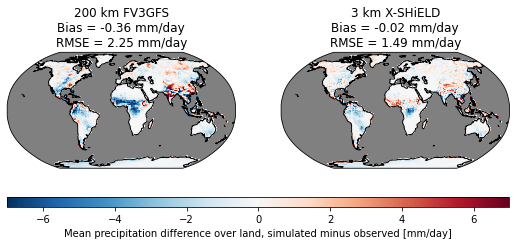

In [10]:
vmin, vmax = -7, 7
cmap = "RdBu_r"

fig, axes = plt.subplots(1, 2, subplot_kw={"projection": ccrs.Robinson()})
fig.set_size_inches(9, 3.5)

for ax, source in zip(axes, ["200 km FV3GFS", "3 km X-SHiELD"]):
    c = ax.pcolormesh(
        bias.longitude,
        bias.latitude,
        bias.sel(source=source).where(land_mask),
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
    )
    ax.coastlines()
    ax.background_patch.set_facecolor("#808080")
    
    b = land_mean_bias.sel(source=source).item()
    r = land_rmse.sel(source=source).item()
    title = f"{source}\nBias = {b:0.2f} mm/day\nRMSE = {r:0.2f} mm/day"
    ax.set_title(title)

label = "Mean precipitation difference over land, simulated minus observed [mm/day]"
fig.colorbar(c, ax=axes.ravel().tolist(), orientation="horizontal", label=label, aspect=50)
fig.savefig("figures/reference-precip-bias.png", bbox_inches="tight", dpi=200)